# ⚛️ H₃⁺ Noiseless VQE — UCC-S vs UCC-D vs UCCSD

This notebook compares three chemistry-inspired VQE ansatzes for the trihydrogen
cation **H₃⁺** using the production API:

    from vqe.core import run_vqe

Each ansatz is evaluated under identical conditions:
- Noiseless simulation (`default.qubit`)
- Optimizer: Adam
- 60 optimisation steps

Ansätze compared:
- **UCC-S** — singles only
- **UCC-D** — doubles only
- **UCCSD** — singles + doubles

For each ansatz we compute:
- Convergence curve
- Final energy
- Final statevector

This notebook is a pure client of the VQE package.


In [1]:
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

from vqe_qpe_common.molecules import get_molecule_config
from vqe.core import run_vqe
from vqe_qpe_common.molecule_viz import plot_molecule
from vqe_qpe_common.plotting import save_plot


In [2]:
# -------------------------------------------------------------
# Molecular system: H₃⁺
# -------------------------------------------------------------
mol = get_molecule_config("H3+")

symbols = mol["symbols"]
coordinates = mol["coordinates"]
basis = mol["basis"]
charge = mol["charge"]

ham, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=charge, basis=basis
)
hf = qchem.hf_state(2, qubits)

print(f"H₃⁺ → {qubits} qubits")
print("HF state =", "|" + "".join(str(int(x)) for x in hf) + "⟩")


H₃⁺ → 6 qubits
HF state = |110000⟩


<Axes: title={'center': 'H₃⁺ (equilateral triangular geometry)'}>

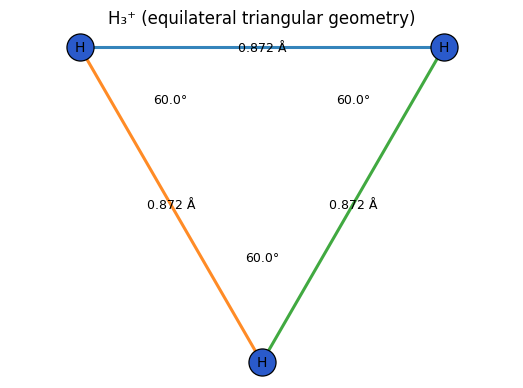

In [3]:
plot_molecule(
    symbols,
    coordinates,
    title="H₃⁺ (equilateral triangular geometry)",
    bonds=[(0, 1), (1, 2), (2, 0)],
    angles=[(0, 1, 2), (1, 2, 0), (2, 0, 1)],
    show_bond_lengths=True,
    show_atom_indices=False,
)


In [4]:
# -------------------------------------------------------------
# Run VQE for UCC-S / UCC-D / UCCSD
# -------------------------------------------------------------
ansatzes = ["UCC-S", "UCC-D", "UCCSD"]
results = {}

for ansatz in ansatzes:
    print(f"\n▶ Running VQE with ansatz: {ansatz}")
    rec = run_vqe(
        molecule="H3+",
        ansatz_name=ansatz,
        optimizer_name="Adam",
        steps=50,
        stepsize=0.2,
        noisy=False,
        plot=False,
        seed=0,
        force=False,
    )

    results[ansatz] = rec



▶ Running VQE with ansatz: UCC-S
Step 01/50: E = -1.258232 Ha
Step 02/50: E = -1.261499 Ha
Step 03/50: E = -1.267383 Ha
Step 04/50: E = -1.259900 Ha
Step 05/50: E = -1.260899 Ha
Step 06/50: E = -1.262275 Ha
Step 07/50: E = -1.266059 Ha
Step 08/50: E = -1.268848 Ha
Step 09/50: E = -1.267546 Ha
Step 10/50: E = -1.264497 Ha
Step 11/50: E = -1.264067 Ha
Step 12/50: E = -1.266668 Ha
Step 13/50: E = -1.269313 Ha
Step 14/50: E = -1.269637 Ha
Step 15/50: E = -1.268078 Ha
Step 16/50: E = -1.266860 Ha
Step 17/50: E = -1.267198 Ha
Step 18/50: E = -1.268418 Ha
Step 19/50: E = -1.269287 Ha
Step 20/50: E = -1.269367 Ha
Step 21/50: E = -1.269011 Ha
Step 22/50: E = -1.268684 Ha
Step 23/50: E = -1.268617 Ha
Step 24/50: E = -1.268834 Ha
Step 25/50: E = -1.269250 Ha
Step 26/50: E = -1.269620 Ha
Step 27/50: E = -1.269649 Ha
Step 28/50: E = -1.269338 Ha
Step 29/50: E = -1.269064 Ha
Step 30/50: E = -1.269189 Ha
Step 31/50: E = -1.269608 Ha
Step 32/50: E = -1.269867 Ha
Step 33/50: E = -1.269732 Ha
Step 34/5

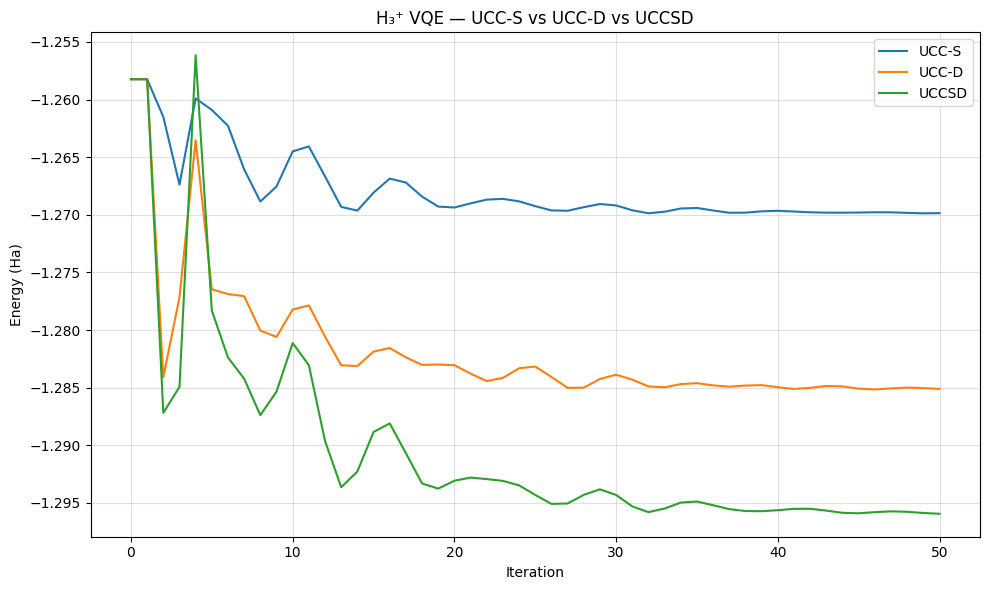

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus_Ansatz_Comparison.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus_Ansatz_Comparison.png'

In [5]:
# -------------------------------------------------------------
# Convergence comparison
# -------------------------------------------------------------
plt.figure(figsize=(10, 6))

for ansatz in ansatzes:
    plt.plot(results[ansatz]["energies"], label=ansatz)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — UCC-S vs UCC-D vs UCCSD")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()

save_plot("H3plus_Ansatz_Comparison.png", kind="vqe", show=True)


In [6]:
# -------------------------------------------------------------
# Statevector reconstruction
# -------------------------------------------------------------
def reconstruct_state(rec):
    """Return complex statevector from stored real/imag components."""
    psi_r = np.array(rec["final_state_real"], dtype=float)
    psi_i = np.array(rec["final_state_imag"], dtype=float)
    return psi_r + 1j * psi_i

threshold = 1e-2

for ansatz in ansatzes:
    print("\n" + "-"*70)
    print(f"Final state decomposition for: {ansatz}")

    psi = reconstruct_state(results[ansatz])
    nz_idx = np.where(np.abs(psi) > threshold)[0]

    terms = []
    for idx in nz_idx:
        amp = psi[idx]
        bit = f"|{idx:0{qubits}b}⟩"
        if abs(amp.imag) < 1e-6:
            term = f"{amp.real:.4f}{bit}"
        else:
            term = f"({amp.real:.4f}+{amp.imag:.4f}j){bit}"
        terms.append(term)

    print(" |ψ⟩ =", " + ".join(terms))



----------------------------------------------------------------------
Final state decomposition for: UCC-S
 |ψ⟩ = 0.1355|101001⟩ + 0.9907|111000⟩

----------------------------------------------------------------------
Final state decomposition for: UCC-D
 |ψ⟩ = -0.0984|001011⟩ + -0.1333|100110⟩ + 0.9862|111000⟩

----------------------------------------------------------------------
Final state decomposition for: UCCSD
 |ψ⟩ = -0.1056|001011⟩ + -0.0118|001110⟩ + -0.0227|100011⟩ + -0.1207|100110⟩ + 0.1288|101001⟩ + 0.0225|101100⟩ + 0.1401|110010⟩ + 0.9679|111000⟩
